In [1]:
import theano
import theano.tensor as T
import lasagne as L

from theano.printing import Print as TPP

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Using gpu device 0: Tesla M2090 (CNMeM is disabled, cuDNN not available)


In [14]:
%run lstm_optimizer.py

In [15]:
input_var = T.vector()

In [16]:
class QuadraticFunction:
    def __init__(self, theta=None, W=None, b=None):
        self.W = W or T.matrix('W')
        self.b = b or T.vector('b')
    
        self.theta = theta or T.vector('theta')
        
        self.func = ((T.dot(self.W, self.theta) - self.b)**2).sum()
        self.grad = theano.grad(self.func, self.theta)
        
        self.params = [self.W, self.b]
        
class RosenbrockFunction:
    def __init__(self, theta=None, a=None, b=None):
        self.a = a or T.scalar('a')
        self.b = b or T.scalar('b')
        self.theta = theta or T.vector('theta')
        
        self.func =  ( (self.a - self.theta[0])**2 + self.b * (theta[1] - theta[0]**2)**2 ) / 1000.0
        self.grad = theano.grad(self.func, self.theta)
        
        self.params = [self.a, self.b]

In [76]:
def build_net(func, n_steps, n_hidden=20, gradient_steps=-1, n_gac=0):
    l_input = L.layers.InputLayer(shape=(None,), input_var=input_var)
    l_optim = LSTMOptimizerLayer(l_input, 
                                 num_units=n_hidden, 
                                 n_steps=n_steps, 
                                 function=func, 
                                 gradient_steps=gradient_steps, 
                                 n_gac=n_gac)
    return l_optim

In [79]:
class LSTMOptimizer:
    def __init__(self, input_var, func, func_params, n_hidden=20, gradient_steps=20, n_gac=0):
        n_steps = T.iscalar()
        self.l_optim = build_net(func, n_steps, n_hidden, gradient_steps=gradient_steps, n_gac=n_gac)
        
        theta_history, loss_history = L.layers.get_output(self.l_optim)
        #loss = np.log(loss_history).sum()
        loss = loss_history.sum()

        self.lr = theano.shared(np.array(0.01, dtype=np.float32))

        params = L.layers.get_all_params(self.l_optim)
        updates = L.updates.adam(loss, params, learning_rate=self.lr)
        
        self.loss_fn = theano.function([input_var, n_steps] + func_params, [theta_history, loss_history], allow_input_downcast=True)
        self.train_fn = theano.function([input_var, n_steps] + func_params, [theta_history, loss_history], updates=updates, allow_input_downcast=True)
        
    def train(self, sample_function, sample_point, n_iter=100, n_epochs=50, batch_size=100, decay_rate=0.96):
        for i in range(n_epochs):
            t = time.time()    

            training_loss_history = []
            for j in range(batch_size):
                params = sample_function()
                theta = sample_point()
                
#                 W_ = np.cast['float32'](np.random.randn(10, 10))
#                 b_ = np.cast['float32'](np.random.randn(10))
#                 #theta = np.cast['float32'](np.random.randn(10))
#                 theta = np.cast['float32'](np.zeros(10))

                theta_history, loss_history = self.train_fn(theta, n_iter, *params)
                loss = sum(loss_history)
                training_loss_history.append(loss_history)

            display.clear_output(wait=True)
            plt.semilogy(np.median(training_loss_history, axis=0))
            plt.show()
            print("Epoch number {}".format(i))
            t = time.time() - t

            print("Time on epoch {}: {}".format(i, t))
            print("Loss on {}: {}; {}".format(i, loss, np.median(training_loss_history, axis=0)[-1]))

            self.lr.set_value((self.lr.get_value() * decay_rate).astype(np.float32))
            
    def optimize(self, theta, func_params, n_iter):
        return self.loss_fn(theta, n_iter, *func_params)

In [18]:
W = T.matrix()
b = T.vector()
    
func = lambda theta: QuadraticFunction(theta, W, b).func

In [50]:
def sgd_step(theta, lr):
    f = func(theta)
    g = theano.grad(f, theta)
    return theta - lr * g, f

sgd_lr = T.scalar()
sgd_thetas, sgd_losses = theano.scan(fn=sgd_step,
                                        outputs_info=[input_var, None],
                                                      non_sequences=sgd_lr,
                                                      n_steps=n_steps)[0]

sgd_fn = theano.function([input_var, n_steps, W, b, sgd_lr], [sgd_thetas, sgd_losses], allow_input_downcast=True)

In [51]:
def momentum_step(theta, old_grad, lr, mu):
    f = func(theta)
    g = theano.grad(f, theta)
    new_grad = mu * old_grad + g
    return theta - lr * g, f, new_grad

momentum_steps = T.iscalar()
momentum_mu = T.scalar()

momentum_thetas, momentum_losses, _ = theano.scan(fn=momentum_step,
                                                  outputs_info=[input_var, None, T.zeros_like(input_var)],
                                                  non_sequences=[sgd_lr, momentum_mu],
                                                  n_steps=n_steps)[0]

momentum_fn = theano.function([input_var, n_steps, W, b, sgd_lr], [momentum_thetas, momentum_losses], allow_input_downcast=True, givens={
        momentum_mu: np.cast['float32'](0.9),
    })

In [80]:
lstm_optimizer = LSTMOptimizer(input_var, func, [W, b], n_hidden=20, gradient_steps=20, n_gac=0)
lstm_gac_optimizer = LSTMOptimizer(input_var, func, [W, b], n_hidden=20, gradient_steps=20, n_gac=5)

In [82]:
def sample_params():
    W_ = np.cast['float32'](np.random.randn(10, 10))
    b_ = np.cast['float32'](np.random.randn(10))
    return W_, b_

def sample_point():
    theta = np.cast['float32'](np.zeros(10))
    return theta

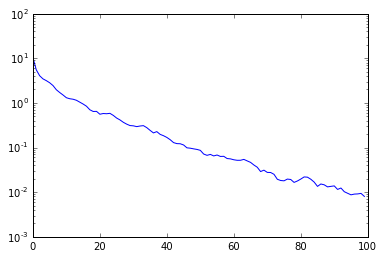

Epoch number 49
Time on epoch 49: 9.898088693618774
Loss on 49: 158.52708204300143; 0.008020324632525444


In [153]:
lstm_optimizer.train(sample_params, sample_point, n_iter=100, n_epochs=50, batch_size=100, decay_rate=0.96)

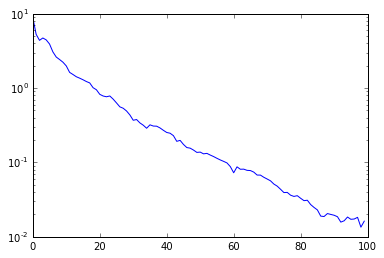

Epoch number 49
Time on epoch 49: 9.20046615600586
Loss on 49: 85.34874675329775; 0.016231924295425415


In [154]:
lstm_gac_optimizer.train(sample_params, sample_point, n_iter=100, n_epochs=50, batch_size=100, decay_rate=0.96)

In [108]:
print(lr.get_value())
lr.set_value(0.0005)

0.00011529214680194855


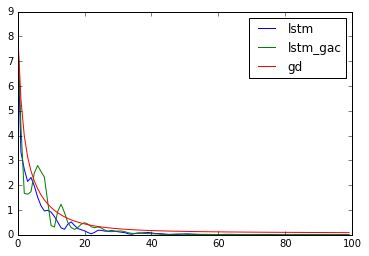

In [88]:
W_, b_ = sample_params()

train_history = momentum_fn(theta, 100, W_, b_, 0.01)[1]

plt.plot(lstm_optimizer.optimize(np.zeros(10, dtype=np.float32), [W_, b_], 100)[1], label='lstm')
plt.plot(lstm_gac_optimizer.optimize(np.zeros(10, dtype=np.float32), [W_, b_], 100)[1], label='lstm_gac')
plt.plot(train_history, label='gd')
plt.legend();

In [89]:
from IPython import display

training_loss_history_lstm = []
training_loss_history_lstm_gac = []
training_loss_history_gd = []
training_loss_history_momentum = []

lrates = np.logspace(-7, 3, num=15)

histories_gd = {lrate: [] for lrate in lrates}
histories_momentum = {lrate: [] for lrate in lrates}

for i in range(20):
    W_, b_ = sample_params()
    theta = sample_point()
    
    losses = lstm_optimizer.optimize(theta, [W_, b_], 100)[1]
    training_loss_history_lstm.append(losses)

    losses = lstm_gac_optimizer.optimize(theta, [W_, b_], 100)[1]
    training_loss_history_lstm_gac.append(losses)
    
    for lrate in lrates:
        train_history = sgd_fn(theta, 100, W_, b_, lrate)[1]
        histories_gd[lrate].append(np.array(train_history))

        train_history = momentum_fn(theta, 100, W_, b_, lrate)[1]
        histories_momentum[lrate].append(np.array(train_history))
    
    print("Loss on {}".format(i))

Loss on 0
Loss on 1
Loss on 2
Loss on 3
Loss on 4
Loss on 5
Loss on 6
Loss on 7
Loss on 8
Loss on 9
Loss on 10
Loss on 11
Loss on 12
Loss on 13
Loss on 14
Loss on 15
Loss on 16
Loss on 17
Loss on 18
Loss on 19


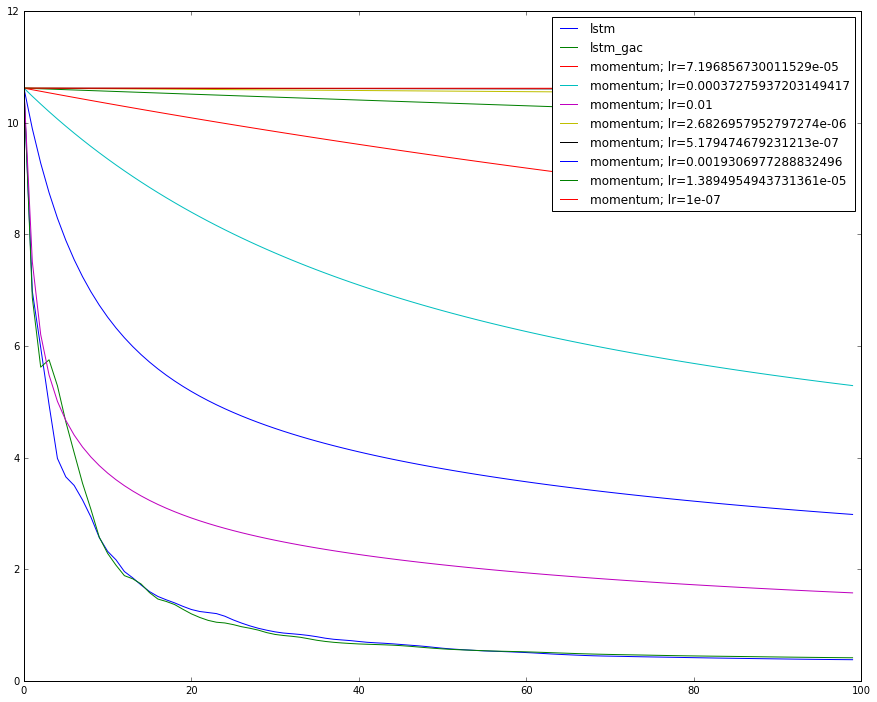

In [92]:
plt.figure(figsize=(15, 12))
plt.plot(np.mean(training_loss_history_lstm, axis=0), label='lstm')
plt.plot(np.mean(training_loss_history_lstm_gac, axis=0), label='lstm_gac')
# for lrate, history in histories_gd.items():
#     if lrate < 1e2:
#         plt.plot(np.mean(history, axis=0), label='gd; lr={}'.format(lrate))
for lrate, history in histories_momentum.items():
    if lrate < 5e-2:
        plt.plot(np.mean(history, axis=0), label='momentum; lr={}'.format(lrate))
plt.legend();

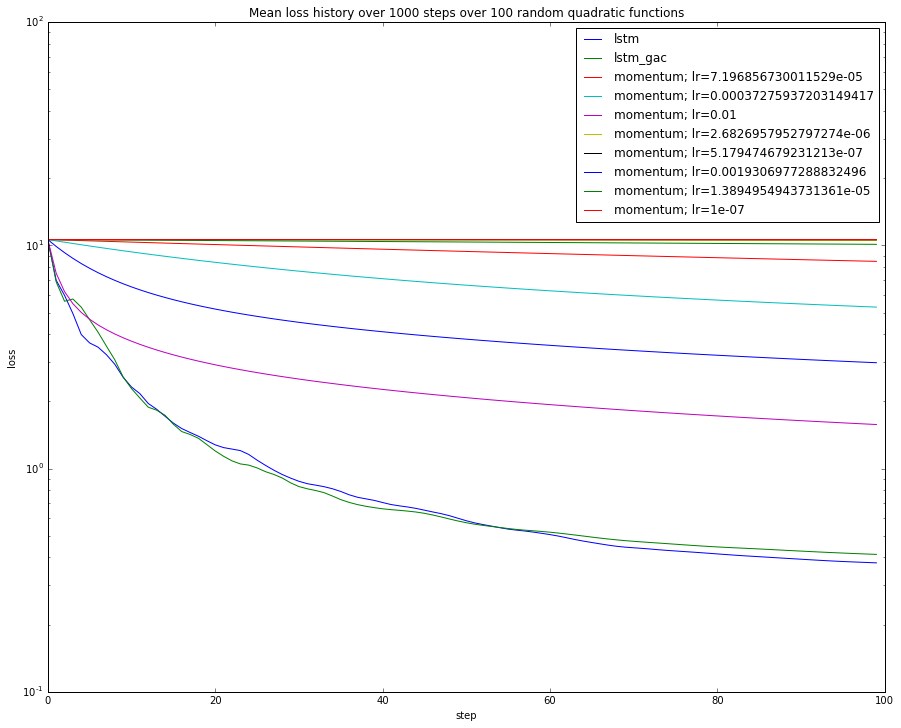

In [95]:
plt.figure(figsize=(15, 12))
plt.title('Mean loss history over 1000 steps over 100 random quadratic functions')
plt.xlabel('step')
plt.ylabel('loss')
plt.semilogy(np.mean(training_loss_history_lstm, axis=0), label='lstm')
plt.semilogy(np.mean(training_loss_history_lstm_gac, axis=0), label='lstm_gac')
# for lrate, history in histories_gd.items():
#     if lrate < 1e1:
#         plt.plot(np.log(np.mean(history, axis=0)), label='gd; lr={}'.format(lrate))
for lrate, history in histories_momentum.items():
    if lrate < 5e-2:
        plt.semilogy(np.mean(history, axis=0), label='momentum; lr={}'.format(lrate))
plt.legend();

In [100]:
W_ = np.cast['float32'](np.random.randn(10, 10))
b_ = np.cast['float32'](np.random.randn(10))
theta = np.cast['float32'](np.zeros(10) * 10)

lstm_history, lstm_losses = lstm_optimizer.optimize(theta, [W_, b_], 100)
lstm_history = np.concatenate([theta.reshape(1, -1), lstm_history], axis=0)

lstm_gac_history, lstm_gac_losses = lstm_gac_optimizer.optimize(theta, [W_, b_], 100)
lstm_gac_history = np.concatenate([theta.reshape(1, -1), lstm_gac_history], axis=0)

pts_hst = {}

for lrate in np.logspace(-3, 3, 15):
    if lrate >= 5e-2:
        continue
        
    sgd_points, sgd_losses = sgd_fn(theta, 100, W_, b_, lrate)
    sdg_points = [theta] + sgd_points
    
    pts_hst[lrate] = (sgd_points, sgd_losses)
    
    sgd_points, sgd_losses = momentum_fn(theta, 100, W_, b_, lrate)
    sdg_points = [theta] + sgd_points
    
    pts_hst[lrate] = (sgd_points, sgd_losses)

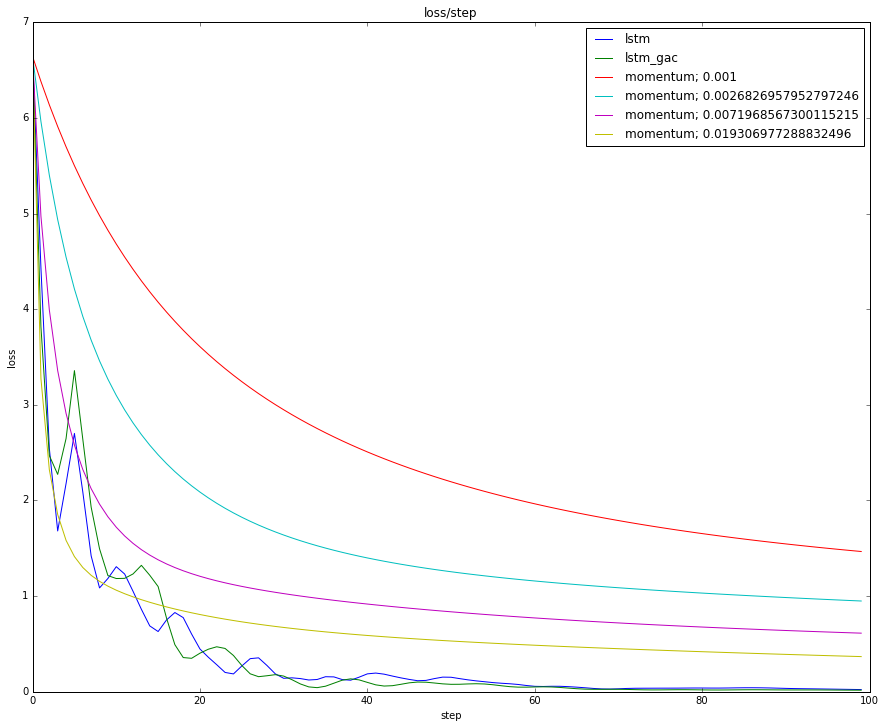

In [101]:
plt.figure(figsize=(15, 12))
plt.title('loss/step')
plt.xlabel('step')
plt.ylabel('loss')
plt.plot(lstm_losses, label='lstm')
plt.plot(lstm_gac_losses, label='lstm_gac')
for lrate in np.logspace(-3, 3, 15):
    if lrate < 5e-2:
        _, lss = pts_hst[lrate]
        plt.plot(lss, label='momentum; {}'.format(lrate))
plt.legend();

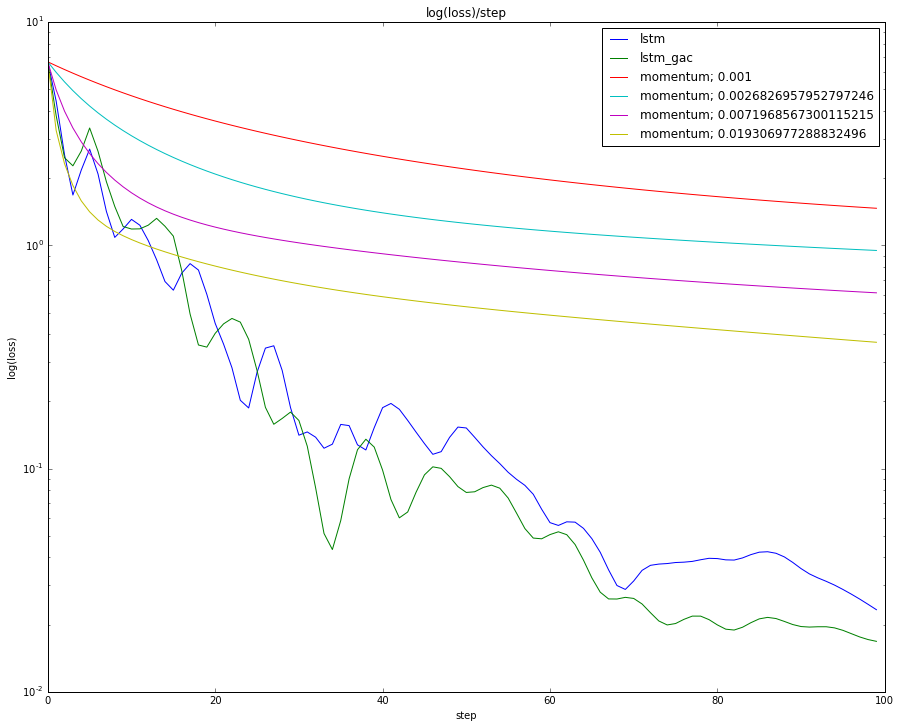

In [102]:
plt.figure(figsize=(15, 12))
plt.title('log(loss)/step')
plt.xlabel('step')
plt.ylabel('log(loss)')
plt.semilogy(lstm_losses, label='lstm')
plt.semilogy(lstm_gac_losses, label='lstm_gac')
for lrate in np.logspace(-3, 3, 15):
    if lrate < 5e-2:
        _, lss = pts_hst[lrate]
        plt.semilogy(lss, label='momentum; {}'.format(lrate))
plt.legend();

In [157]:
W_ = np.cast['float32'](np.random.randn(2, 2))
b_ = np.cast['float32'](np.random.randn(2))
theta = np.cast['float32'](np.zeros(2))

lstm_history, lstm_losses = lstm_optimizer.optimize(theta, [W_, b_], 100)
lstm_history = np.concatenate([theta.reshape(1, -1), lstm_history], axis=0)

lstm_gac_history, lstm_gac_losses = lstm_gac_optimizer.optimize(theta, [W_, b_], 100)
lstm_gac_history = np.concatenate([theta.reshape(1, -1), lstm_gac_history], axis=0)

pts_hst = {}

for lrate in np.logspace(-3, 3, 15):
    if lrate >= 5e-2:
        continue
        
    sgd_points, sgd_losses = sgd_fn(theta, 100, W_, b_, lrate)
    sdg_points = [theta] + sgd_points
    
    pts_hst[lrate] = (sgd_points, sgd_losses)
    
    sgd_points, sgd_losses = momentum_fn(theta, 100, W_, b_, lrate)
    sdg_points = [theta] + sgd_points
    
    pts_hst[lrate] = (sgd_points, sgd_losses)

KeyError: 0.0517947467923121

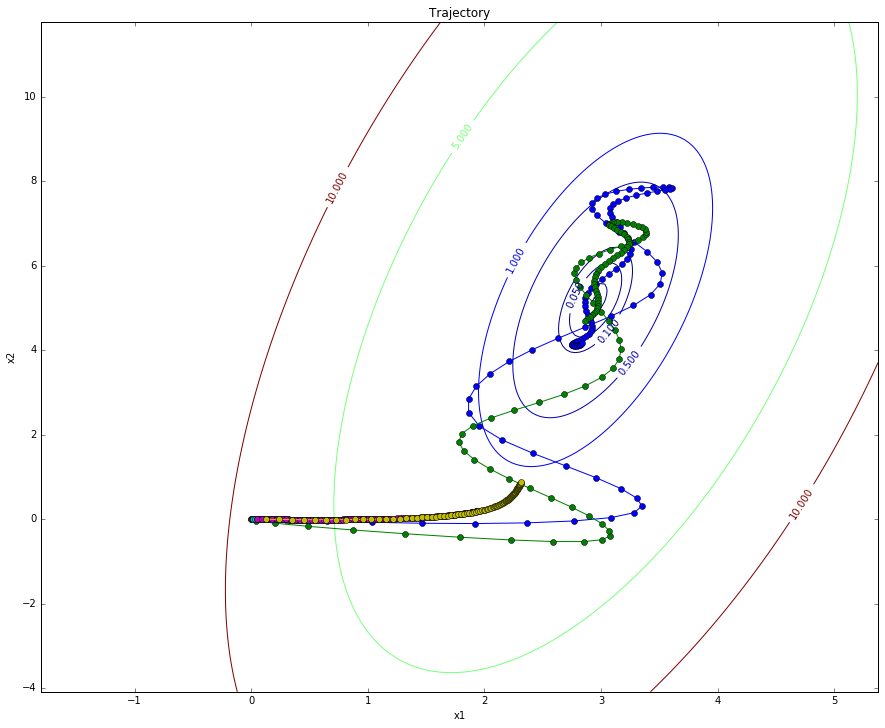

In [160]:
#min_x = min(min(lstm_history.T[0]), 1.2*a_)
#max_x = max(max(lstm_history.T[0]), 1.2*a_)
#min_y = min(min(lstm_history.T[1]), 1.2*a_**2)
#max_y = max(max(lstm_history.T[1]), 1.2*a_**2)

theta_opt = np.linalg.pinv(W_).dot(b_)

min_x = min(lstm_history.T[0])
max_x = max(lstm_history.T[0])
min_y = min(lstm_history.T[1])
max_y = max(lstm_history.T[1])

delta_x = (max_x - min_x) / 100.
delta_y = (max_y - min_y) / 100.

x = np.arange(2 * min_x - (min_x + max_x) / 2, 2 * max_x - (min_x + max_x) / 2, delta_x)
y = np.arange(2 * min_y - (min_y + max_y) / 2, 2 * max_y - (min_y + max_y) / 2, delta_y)
# x = np.arange(min_x, max_x, delta_x)
# y = np.arange(min_y, max_y, delta_y)
X, Y = np.meshgrid(x, y)

Z = np.zeros(X.shape)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        z = ((W_.dot(np.array([X[i][j], Y[i][j]])) - b_)**2).sum()
        Z[i][j] = z

#Z = ((W.dot(X) - b_)**2).sum()

plt.figure(figsize=(15, 12))
plt.title('Trajectory')

CS = plt.contour(X, Y, Z, levels=[1e-4, 1e-3, 1e-2, 5e-2, 1e-1, 5e-1, 1e-0, 5e-0, 1e1])
plt.clabel(CS, inline=1, fontsize=10)

plt.plot([theta_opt[0]], [theta_opt[1]], marker='x', color='k')

plt.xlabel('x1')
plt.ylabel('x2')
plt.plot(lstm_history.T[0], lstm_history.T[1], marker='o', label='lstm')
plt.plot(lstm_gac_history.T[0], lstm_gac_history.T[1], marker='o', label='lstm_gac')
for lrate in np.logspace(-3, 3, 15):
    if lrate < 5e-1:
        hist, _ = pts_hst[lrate]
        plt.plot(np.array(hist).T[0], np.array(hist).T[1], label='momentum; {}'.format(lrate), marker='o')
plt.legend(loc=2);

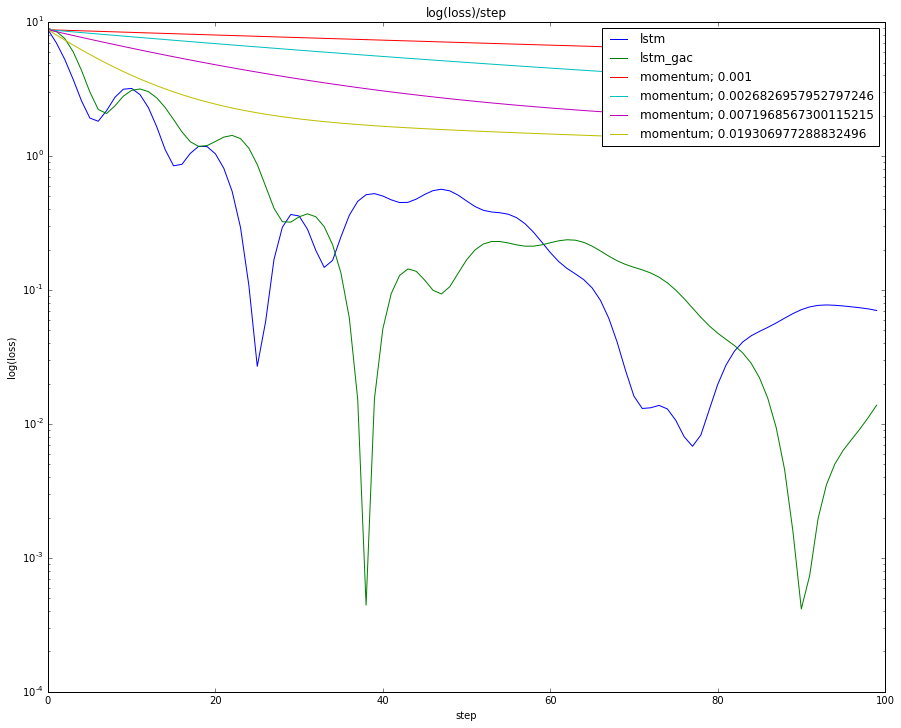

In [159]:
plt.figure(figsize=(15, 12))
plt.title('log(loss)/step')
plt.xlabel('step')
plt.ylabel('log(loss)')
plt.semilogy(lstm_losses, label='lstm')
plt.semilogy(lstm_gac_losses, label='lstm_gac')
for lrate in np.logspace(-3, 3, 15):
    if lrate < 5e-2:
        _, lss = pts_hst[lrate]
        plt.semilogy(lss, label='momentum; {}'.format(lrate))
plt.legend();

In [149]:
clss_lstm = []
clss_lstm_gac = []

for n_c in range(2, 100):
    print(n_c)
    W_ = np.random.randn(n_c, n_c).astype(np.float32)
    b_ = np.random.randn(n_c).astype(np.float32)
    
    cl = 1. / n_c**2 * lstm_optimizer.optimize(np.zeros(n_c, dtype=np.float32), [W_, b_], 100)[1][-1]
    clss_lstm.append(cl)
    
    cl = 1. / n_c**2 * lstm_gac_optimizer.optimize(np.zeros(n_c, dtype=np.float32), [W_, b_], 100)[1][-1]
    clss_lstm_gac.append(cl)

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


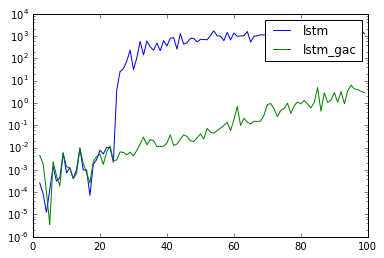

In [145]:
plt.semilogy(range(2, 100), clss_lstm, label='lstm')
plt.semilogy(range(2, 100), clss_lstm_gac, label='lstm_gac')
plt.legend();

In [155]:
from IPython import display

training_loss_history_lstm = []
training_loss_history_lstm_gac = []
training_loss_history_gd = []
training_loss_history_momentum = []

lrates = np.logspace(-7, 3, num=15)

histories_gd = {lrate: [] for lrate in lrates}
histories_momentum = {lrate: [] for lrate in lrates}

for i in range(20):
    W_, b_ = sample_params()
    theta = sample_point()
    
    losses = lstm_optimizer.optimize(theta, [W_, b_], 100)[1]
    training_loss_history_lstm.append(losses)

    losses = lstm_gac_optimizer.optimize(theta, [W_, b_], 100)[1]
    training_loss_history_lstm_gac.append(losses)
    
    for lrate in lrates:
        train_history = sgd_fn(theta, 100, W_, b_, lrate)[1]
        histories_gd[lrate].append(np.array(train_history))

        train_history = momentum_fn(theta, 100, W_, b_, lrate)[1]
        histories_momentum[lrate].append(np.array(train_history))
    
    print("Loss on {}".format(i))

Loss on 0
Loss on 1
Loss on 2
Loss on 3
Loss on 4
Loss on 5
Loss on 6
Loss on 7
Loss on 8
Loss on 9
Loss on 10
Loss on 11
Loss on 12
Loss on 13
Loss on 14
Loss on 15
Loss on 16
Loss on 17
Loss on 18
Loss on 19


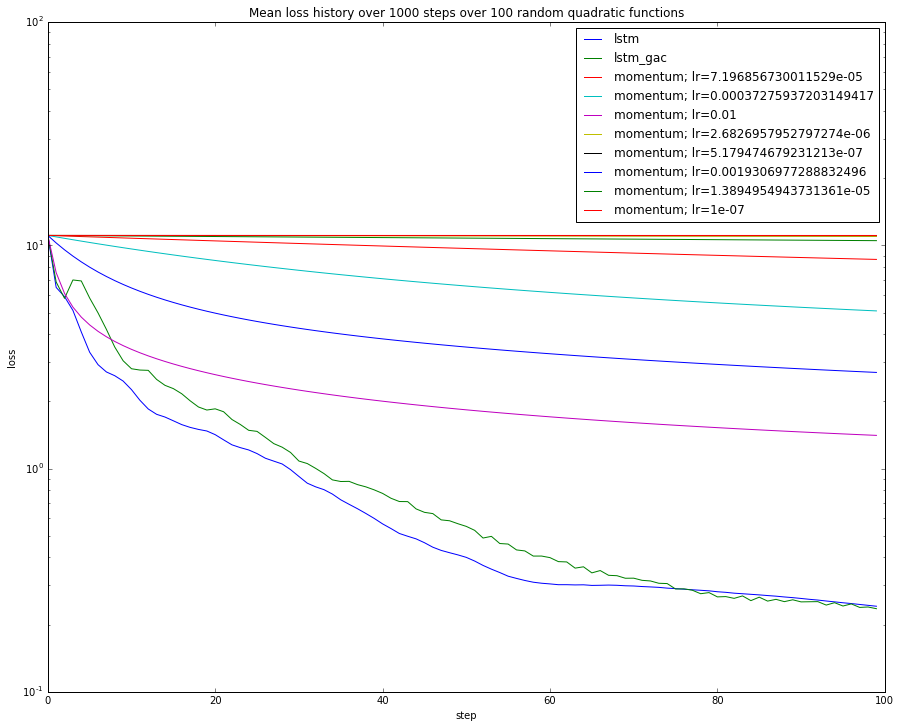

In [156]:
plt.figure(figsize=(15, 12))
plt.title('Mean loss history over 1000 steps over 100 random quadratic functions')
plt.xlabel('step')
plt.ylabel('loss')
plt.semilogy(np.mean(training_loss_history_lstm, axis=0), label='lstm')
plt.semilogy(np.mean(training_loss_history_lstm_gac, axis=0), label='lstm_gac')
# for lrate, history in histories_gd.items():
#     if lrate < 1e1:
#         plt.plot(np.log(np.mean(history, axis=0)), label='gd; lr={}'.format(lrate))
for lrate, history in histories_momentum.items():
    if lrate < 5e-2:
        plt.semilogy(np.mean(history, axis=0), label='momentum; lr={}'.format(lrate))
plt.legend();